## CO2 flux analysis

### Methods:

1. Load geometries and inversion CO2 data and preprocess as necessary.
2. Select the ROI (region of interest), initially using a small test region.
3. Create a grouping coordinate that divides growing and non-growing seasons.   
    - Initially this can be done manually. Later consider fitting a harmonic to divide seasons.  
4. For each year and season, calculate the CO2 flux sum.
5. For each year, get the difference between growing and non-growing season.
    - This is the CO2 flux amplitude that can then be related to atmospheric CO2 and driving variables.  

### Details

#### Geometries 

Geometry objects are used to mask or filter the data, e.g. continents, above 50N, ecoregions, test region.

#### Applying same crs to all data

Using the common WGS84: EPSG 4326. This should be set to all rasters used. If the crs was WGS84 but the property was not set, then use:  
`mydata.rio.write_crs("epsg:4326", inplace=True)`  

Else, change the crs with   
`mydata.rio.reproject("EPSG:4326")`  

When adding more datasets, these can be adjusted to the first using:  
`mydata2 = mydata2.rio.reproject_match(mydata)`  

#### Set a missing data value

Set a missing data value to be same across all data, e.g. -9999.   

`mydata.rio.set_nodata(-9999, inplace=True)` # will set the nadata attrribute without modifying the data
`mydata.rio.write_nodata(-9999, inplace=True)` # will write to the array (I guess replacing the existing missing data value?) Need to test.  

Note that the reproject_match method from above will modify the nodata value of mydata2 to match that of mydata.  

Use the following to mask the missing data:  
```
nodata = raster.rio.nodata
raster = raster.where(raster != nodata)
raster.rio.write_nodata(nodata, encoded=True, inplace=True)
```

In [116]:
# Get all required packages
import ee
# from osgeo import gdal
# from pyproj import CRS
# import geemap as gm

import rioxarray as rio
import xarray as xr
import pandas as pd
import numpy as np

In [117]:
# Setup for Earth Engine
# ee.Authenticate()
ee.Initialize()

In [118]:
# Some common setting:
nodata = -9999.0
epsg_crs = 4326

#### Load geometries data

/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot:>

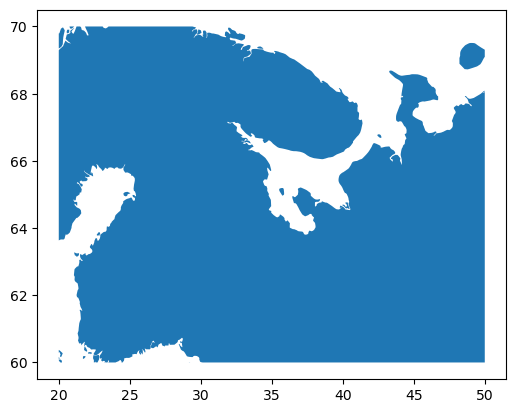

In [119]:
import geopandas as gpd
from shapely.geometry import box

conts_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/continents.geojson'
north50_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/north50.geojson'
testrect_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/testrect.geojson'

conts = gpd.read_file(conts_file)
north50 = gpd.read_file(north50_file)
testrect = gpd.read_file(testrect_file)
conts_north50 = conts.clip(north50)
testarea = conts.clip(testrect)
# print(conts.crs)
# print(north50.crs)
# conts.plot()
# north50.plot()
testarea.plot()
# conts_north50.plot()

### Load CO2 from inversion and do some processing

In [120]:
# Open data with Gdal and get the CRS information
# file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.tiff'
file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.nc'

# All three file reading methods read in the attributes differently.
# co2Inv = rio.open_rasterio(file_path)
# co2Inv = xr.open_dataset(file_path, engine="rasterio", variable='co2flux_land')
co2Inv_List = rio.open_rasterio(file_path, variable='co2flux_land')
co2Inv = co2Inv_List['co2flux_land']  # Extracting the dataarray from the list
co2Inv = co2Inv.rename({'mtime': 'time'})  # Rename the time dimension and coordinate to something standard.
co2Inv = co2Inv.rename({'x': 'longitude'})  # Rename the time dimension and coordinate to something standard.
co2Inv = co2Inv.rename({'y': 'latitude'})  # Rename the time dimension and coordinate to something standard.
co2Inv.attrs['units'] = 'PgC/yr'  # For some reason the units is a tuple of repeating values. Replacing with single value.
co2Inv.rio.write_crs(4326, inplace=True)  # Set the crs
co2Inv.coords.__delitem__('spatial_ref')

<xarray.DataArray 'co2flux_land' (time: 13514, latitude: 90, longitude: 144)>
[175141440 values with dtype=float32]
Coordinates:
  * time         (time) object 1985-01-01 11:59:59 ... 2021-12-31 12:00:00
  * longitude    (longitude) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * latitude     (latitude) float64 89.0 87.0 85.0 83.0 ... -85.0 -87.0 -89.0
    spatial_ref  int64 0
Attributes:
    itime#bounds:             itime_bounds
    itime#long_name:          internal time
    itime#units:              seconds since 2000-01-01
    lat#bounds:               lat_bounds
    lat#long_name:            latitude
    lat#standard_name:        latitude
    lat#units:                degrees_north
    lon#bounds:               lon_bounds
    lon#long_name:            longitude
    lon#standard_name:        longitude
    lon#units:                degrees_east
    NETCDF_DIM_EXTRA:         {mtime}
    NETCDF_DIM_mtime_DEF:     [1.3514e+04 4.0000e+00]
    NETCDF_DIM_mtime_VALUES:  [-4.73256001e+08 -4.73169601e+08 -4.73083201e+0...
    cell_measures:            area: dxyp
    cell_methods:             lon: lat: sum
    long_name:                Land-atmosphere co2 flux
    units:                    PgC/yr
    _FillValue:               9.96921e+36
    scale_factor:             1.0
    add_offset:               0.0

In [121]:
# Setting nodata
co2Inv = co2Inv.rio.write_nodata(nodata)  # Set the new nodata value
co2Inv.data = np.where(co2Inv.data == co2Inv.rio.nodata, nodata, co2Inv.data) # If there are any nodata values, replace them with the new definition
co2Inv = co2Inv.rio.write_nodata(co2Inv.rio.nodata, encoded=True, inplace=True)  # nodata value is enconded (not sure what this is or if necessary)

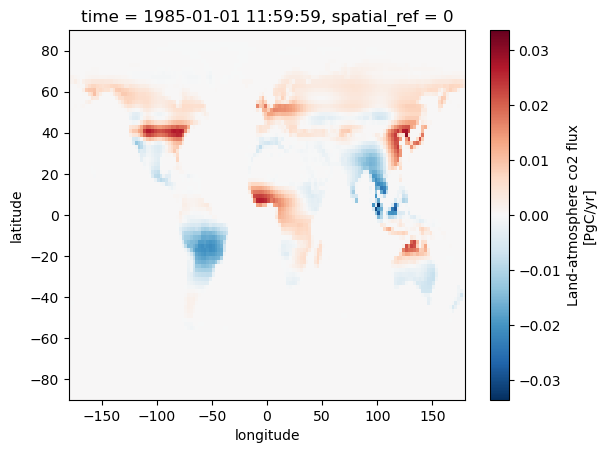

In [122]:
# Check data
# print(co2Inv.attrs)
co2Inv[0].plot()
# co2Inv = co2Inv.reindex({'lat':co2Inv.lat[::-1]})  # Reindexing not necessary. Did open rasterio 

In [123]:
# Cut the data to a smaller region for testing
co2InvT = co2Inv.rio.clip(testarea.geometry, testarea.crs, all_touched=True)
# co2IT = co2Inv.rio.clip(north50.geometry, north50.crs, all_touched=True)

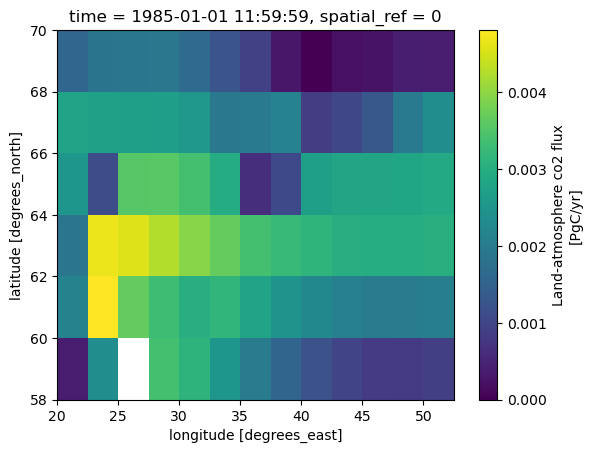

In [124]:
# print(co2IT)
co2InvT[0].plot()

In [125]:
months = co2InvT.time.dt.month.data
# season = np.where(np.logical_or(months < 4, months > 9), 0, 1)
season = np.where((months < 4) | (months > 9), 0, 1)
groups = co2InvT.time.dt.year.data + (season/10)
co2InvT['groups'] = ('time', groups)
# co2IT['season'] = ('time', season)
# groups[0:365]

array([1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. , 1985. ,
       1985. , 1985. , 1985.1, 1985.1, 1985.1, 1985.1, 1985.1, 1985.1,
       1985.1, 1985.1, 1985.1, 1985.1, 1985.1, 1985.1, 1985.1, 1985.1,
       1985.1, 1985.1, 1985.1, 1985.1, 1985.1, 1985.1, 1985.1, 1985.1,
      

In [129]:
# co2InvS = co2Inv.groupby(['time.year', 'season']).mean()  # grouping by two variables is not supported in xarray!
co2InvTG = co2InvT.groupby('groups').mean()

In [139]:
# Check the output
print(co2InvTG[0:,0,0])
print(co2InvTG.coords['groups'])

<xarray.DataArray 'co2flux_land' (groups: 74)>
array([ 0.00126377, -0.00206301,  0.00101997, -0.00228562,  0.00138282,
       -0.00208494,  0.00204435, -0.00173712,  0.00211477, -0.00230766,
        0.00147518, -0.00253105,  0.00144811, -0.00242557,  0.00144693,
       -0.00249305,  0.00166356, -0.00216476,  0.00117927, -0.00284734,
        0.00192599, -0.0019676 ,  0.00160051, -0.00240707,  0.00128169,
       -0.00215166,  0.00168525, -0.00213336,  0.00179143, -0.00211786,
        0.0016506 , -0.00231079,  0.00164322, -0.00251972,  0.0013789 ,
       -0.00168922,  0.0017824 , -0.00236371,  0.00165756, -0.00276536,
        0.00168411, -0.0029359 ,  0.00175891, -0.00253395,  0.00182193,
       -0.00237107,  0.00216065, -0.00262067,  0.00185149, -0.00266862,
        0.00179599, -0.0020172 ,  0.00229383, -0.00238182,  0.00168356,
       -0.0018085 ,  0.00274609, -0.00215789,  0.00185542, -0.00263925,
        0.00162232, -0.00270061,  0.00124244, -0.0035124 ,  0.00212651,
       -0.0025538

In [161]:
# Add again the coordinate representing years
years = np.round(co2InvTG.coords['groups'].data)
co2InvTG['year'] = ('groups', years)

# Check values
# print(co2InvTG.coords['year'])
# co2InvTG.where(co2InvTG.year==1985, drop=True)

# Calculate the difference between the seasonal averages
def diff(x):
    return(x[0] - x[1])
co2InvTD = co2InvTG.groupby('year').map(diff)

<xarray.DataArray 'year' (groups: 74)>
array([1985., 1985., 1986., 1986., 1987., 1987., 1988., 1988., 1989.,
       1989., 1990., 1990., 1991., 1991., 1992., 1992., 1993., 1993.,
       1994., 1994., 1995., 1995., 1996., 1996., 1997., 1997., 1998.,
       1998., 1999., 1999., 2000., 2000., 2001., 2001., 2002., 2002.,
       2003., 2003., 2004., 2004., 2005., 2005., 2006., 2006., 2007.,
       2007., 2008., 2008., 2009., 2009., 2010., 2010., 2011., 2011.,
       2012., 2012., 2013., 2013., 2014., 2014., 2015., 2015., 2016.,
       2016., 2017., 2017., 2018., 2018., 2019., 2019., 2020., 2020.,
       2021., 2021.])
Coordinates:
    spatial_ref  int64 0
  * groups       (groups) float64 1.985e+03 1.985e+03 ... 2.021e+03 2.021e+03
    year         (groups) float64 1.985e+03 1.985e+03 ... 2.021e+03 2.021e+03


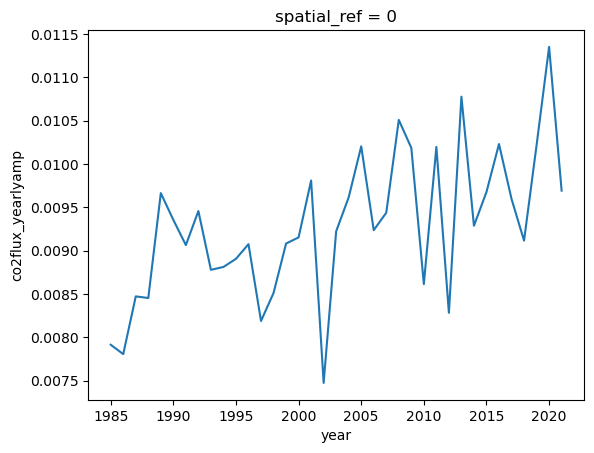

In [176]:
# Just renaming the xarray data array
co2InvTD = co2InvTD.rename('co2flux_yearlyamp')

# This line calculates the mean across the given dimensions, so for the entire region in this case.
regDiffMean = co2InvTD.mean(['longitude','latitude'])

# The data is now a one dimensional time series, so it is plotted as a line graph.
regDiffMean.plot()

In [178]:
co2InvTD.dims

('year', 'latitude', 'longitude')

In [187]:
# Calculate trends
from xarrayutils.utils import linear_trend
fluxamp_trends = linear_trend(co2InvTD, 'year')

/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.Dataset>
Dimensions:    (longitude: 13, latitude: 6)
Coordinates:
  * longitude  (longitude) float64 21.25 23.75 26.25 28.75 ... 46.25 48.75 51.25
  * latitude   (latitude) float64 69.0 67.0 65.0 63.0 61.0 59.0
Data variables:
    slope      (latitude, longitude) float64 2.842e-05 3.464e-05 ... 8.369e-05
    intercept  (latitude, longitude) float64 0.003604 0.00435 ... 0.01102
    r_value    (latitude, longitude) float64 0.6271 0.6238 ... 0.5959 0.6012
    p_value    (latitude, longitude) float64 3.279e-05 3.708e-05 ... 8.329e-05
    std_err    (latitude, longitude) float64 5.968e-06 7.337e-06 ... 1.88e-05

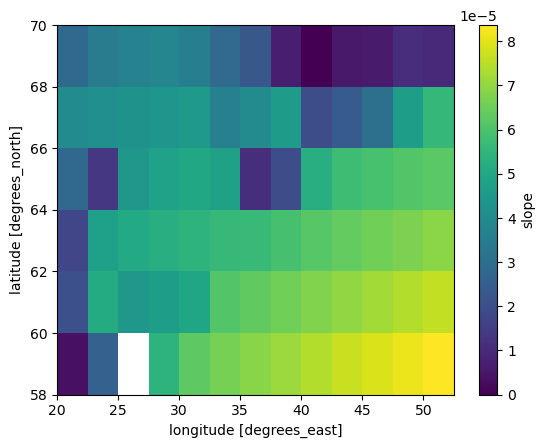

In [189]:
fluxamp_trends.slope.plot() #(robust=True)
fluxamp_trends